## Filter Decomposition - Multi Output Regression Approach

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from fimage import FImage
from fimage.filters import Contrast, Brightness, Saturation, Hue, Exposure, Grayscale, Sharpen, Sepia,  Vibrance, Posterize, Noise

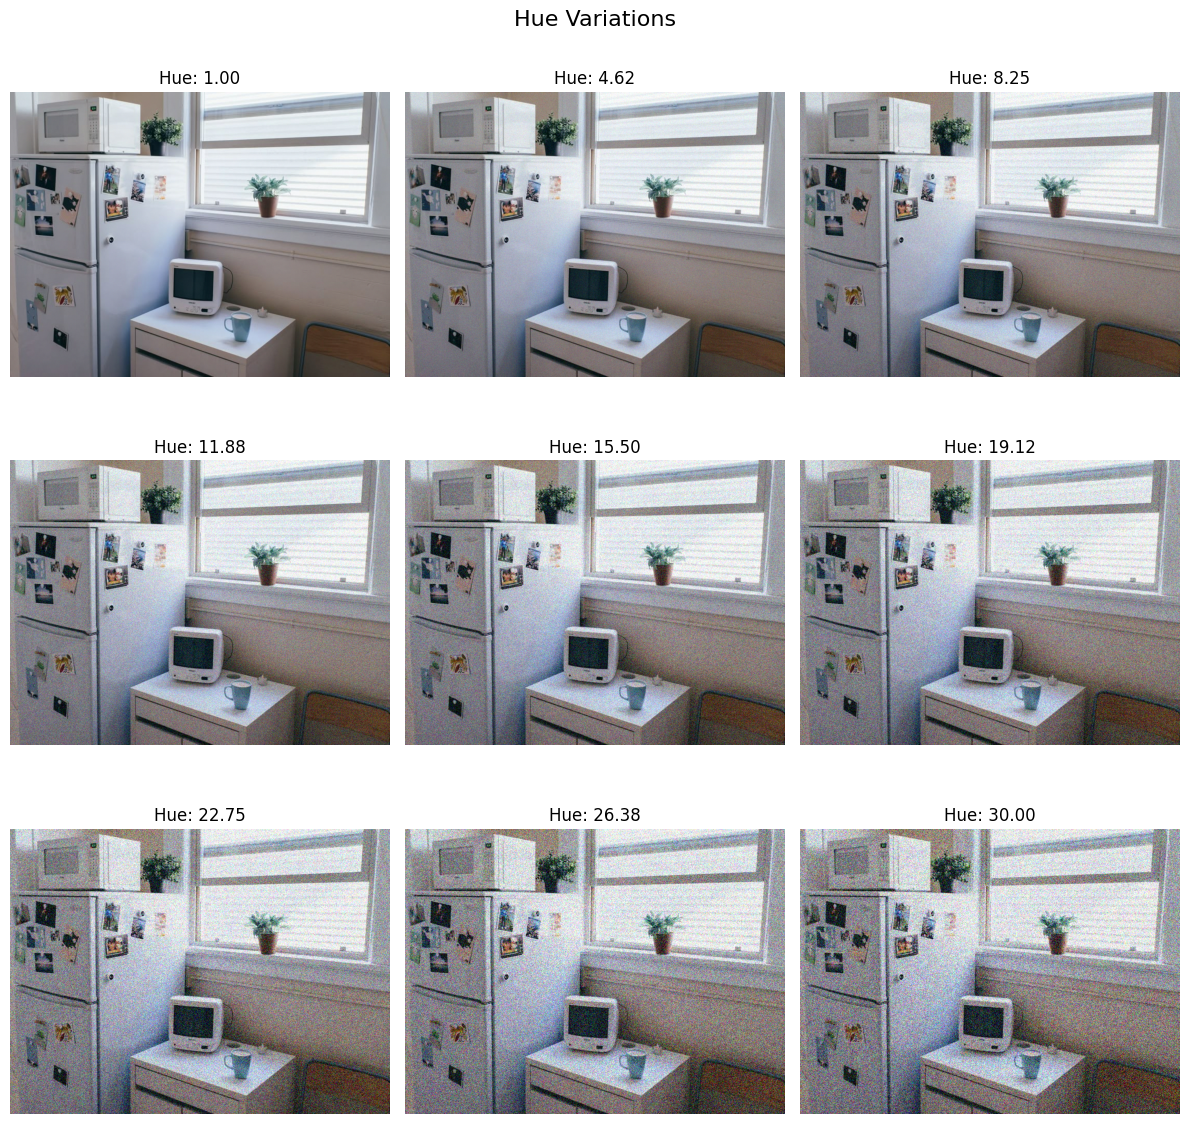

In [2]:
def plot_hue_variations(image_path, levels=9):
    # Create figure with 3x3 subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Hue Variations', fontsize=16)
    
    # Load original image using FImage
    
    # Generate hue values from -1.0 to 1.0
    hue_values = np.linspace(1.0, 30.0, levels)
    
    # Plot each variation
    for idx, hue in enumerate(hue_values):
        row = idx // 3
        col = idx % 3
        
        # Create a copy and apply hue filter

        img = FImage(image_path)
        img.apply(Noise(hue))
        
        # Display the image
        axes[row, col].imshow(img.image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Hue: {hue:.2f}')
    
    plt.tight_layout()
    plt.show()

# Example usage with your image path
img_path = "test_image.jpg"
plot_hue_variations(img_path)

### Loading Dataset

In [37]:
IMAGE_DIR = 'results/images'
METADATA_PATH = 'results/metadata.csv'
BATCH_SIZE = 16
NUM_FILTERS = 9  # Contrast, Brightness, Saturation, Hue, Exposure
IMG_SIZE = (260, 260)

In [38]:
df = pd.read_csv(METADATA_PATH)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [40]:
class FilterDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None, normalize_intensities=True):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.filter_cols = self.df.columns.to_list()[1:]  
        self.normalize_intensities = normalize_intensities
        self.max_values = torch.tensor(list(map(lambda c: self.df[c].max(), self.filter_cols)))
        # TODO: if some filter is in negatives this breaks
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.image_dir, row['Id'])).convert("RGB")
        
        intensities = torch.tensor(row[self.filter_cols].values.astype(np.float32))
        
        if self.normalize_intensities:
            intensities = intensities / self.max_values
        
        if self.transform:
            image = self.transform(image)
        
        return image, intensities

In [41]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FilterDataset(METADATA_PATH, IMAGE_DIR, transform=transform, normalize_intensities=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


In [42]:
_, l = next(iter(train_loader))

### Model Architecture

In [ ]:
class MultiOutputEfficientNet(nn.Module):
    def __init__(self, num_filters=NUM_FILTERS):
        super(MultiOutputEfficientNet, self).__init__()
        self.base_model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_filters)
        )
    
    def forward(self, x):
        return self.base_model(x)
      

model = MultiOutputEfficientNet()
model = model.to(device)

### Training 

In [44]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{10}]  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")

### Loss and Accuracy Plots

In [ ]:
plt.title('Training and Validation Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

### Evaluation

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_targets = [], [] 

    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)

            all_preds.append(y_pred.cpu())
            all_targets.append(labels.cpu())


    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # 1) MSE per filter (vector of length 5) and overall
    mse_per_filter = mean_squared_error(all_targets, all_preds, multioutput='raw_values')
    mse_overall    = mean_squared_error(all_targets, all_preds, multioutput='uniform_average')

    # 2) RMSE (take sqrt of each MSE)
    rmse_per_filter = mse_per_filter ** 0.5
    rmse_overall    = mse_overall ** 0.5

    # 3) MAE per filter and overall
    mae_per_filter = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
    mae_overall    = mean_absolute_error(all_targets, all_preds, multioutput='uniform_average')

    # 4) R^2 per filter and overall (can also do multioutput='variance_weighted')
    r2_per_filter = []

    for i in range(all_targets.shape[1]):
        r2_per_filter.append(r2_score(all_targets[:, i], all_preds[:, i]))

    r2_overall = r2_score(all_targets, all_preds, multioutput='uniform_average')

    metrics = {
        "mse_per_filter":    mse_per_filter.tolist(),
        "mse_overall":       float(mse_overall),
        "rmse_per_filter":   rmse_per_filter.tolist(),
        "rmse_overall":      float(rmse_overall),
        "mae_per_filter":    mae_per_filter.tolist(),
        "mae_overall":       float(mae_overall),
        "r2_per_filter":     r2_per_filter,
        "r2_overall":        float(r2_overall),
    }
    return metrics

In [ ]:
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

In [ ]:
metrics = evaluate(model, test_loader)
metrics

{'mse_per_filter': [0.05461079254746437,
  0.04261424019932747,
  0.11731751263141632,
  0.09723078459501266,
  0.12239837646484375,
  0.12621673941612244,
  0.061545178294181824,
  0.061424124985933304,
  0.010311617515981197],
 'mse_overall': 0.07707437127828598,
 'rmse_per_filter': [0.23368951678276062,
  0.20643216371536255,
  0.3425164520740509,
  0.31181851029396057,
  0.34985479712486267,
  0.3552699387073517,
  0.24808301031589508,
  0.24783891439437866,
  0.10154613852500916],
 'rmse_overall': 0.2776227139091576,
 'mae_per_filter': [0.18069054186344147,
  0.1604270339012146,
  0.2657794952392578,
  0.2266005575656891,
  0.2895045578479767,
  0.30113422870635986,
  0.1974790394306183,
  0.17811891436576843,
  0.07753252983093262],
 'mae_overall': 0.2085852026939392,
 'r2_per_filter': [0.5295804738998413,
  0.6299932599067688,
  -0.02529442310333252,
  0.13207107782363892,
  0.02865070104598999,
  -0.09226739406585693,
  0.4448237419128418,
  0.48130345344543457,
  0.91178137063

In [ ]:
uh = pd.read_csv(METADATA_PATH)
print(uh.head())

                 Id  Contrast  Brightness  Saturation  Hue  Exposure  \
0    cifar_0_v1.png        39          10          23    0        30   
1    cifar_1_v1.png        68           0           0   75        20   
2   cifar_10_v1.png        56          18           0   13        21   
3  cifar_100_v1.png         0          13          56    0         0   
4  cifar_101_v1.png         0           0          92   42         0   

   Vibrance  Sepia  Sharpen  Noise  
0         0      0        0      9  
1        75     57       28     25  
2        46     19        0      0  
3         0      0        0      2  
4         0     56        0      0  


In [ ]:
filter_cols = uh.columns.to_list()[1:]
filter_cols

['Contrast',
 'Brightness',
 'Saturation',
 'Hue',
 'Exposure',
 'Vibrance',
 'Sepia',
 'Sharpen',
 'Noise']

In [ ]:
maxes = list(map(lambda c: uh[c].max(), filter_cols))
maxes

[75, 30, 100, 100, 30, 100, 100, 75, 30]

In [ ]:
def visualize_predictions(model, dataloader, idx):
    model.eval()

    with torch.inference_mode():
        inputs, targets = next(iter(dataloader))
        inputs, targets = inputs.to(device), targets.to(device)
        y_pred = model(inputs)

        first_prediction = y_pred[idx].cpu().numpy()
        first_target = targets[idx].cpu().numpy()

        for (pred, target, mx, f) in zip(first_prediction, first_target, maxes, filter_cols):
            scaled_pred = pred * mx
            scaled_target = target * mx

            print(f"Filter: {f}")
            print(f"Predicted filter: {scaled_pred:.4f}")
            print(f"Actual filter: {scaled_target:.4f}")
            print("----------------------")

        # TODO then apply the predicted filters to see how it worked

In [ ]:
def infer_image(model, img_path, max_value=85.0):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        pred = model(input_tensor).squeeze(0).cpu().numpy()

    scaled_pred = pred * max_value
    filter_names = ['Contrast', 'Brightness', 'Saturation', 'Hue', 'Exposure', 'Vibrance', 'Sepia', 'Sharpen', 'Noise']

    print(f"Predicted filters for {os.path.basename(img_path)}:")
    for name, value in zip(filter_names, scaled_pred):
        print(f"{name}: {value:.2f}")

In [ ]:
visualize_predictions(model, test_loader,12)

Filter: Contrast
Predicted filter: 39.6782
Actual filter: 65.0000
----------------------
Filter: Brightness
Predicted filter: 18.5720
Actual filter: 22.0000
----------------------
Filter: Saturation
Predicted filter: 42.4524
Actual filter: 69.0000
----------------------
Filter: Hue
Predicted filter: 26.2293
Actual filter: 18.0000
----------------------
Filter: Exposure
Predicted filter: 9.7277
Actual filter: 12.0000
----------------------
Filter: Vibrance
Predicted filter: 10.4838
Actual filter: 0.0000
----------------------
Filter: Sepia
Predicted filter: 17.8070
Actual filter: 0.0000
----------------------
Filter: Sharpen
Predicted filter: -2.9531
Actual filter: 0.0000
----------------------
Filter: Noise
Predicted filter: 1.4846
Actual filter: 0.0000
----------------------
